In [1]:
## Note that for the KNN another pipeline was used. Therefore it is not part of the code anymore. The plots are still in the original format

In [2]:
import pandas as pd
import random
import numpy as np

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, make_scorer, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
random.seed(42)

In [4]:
PATH=r"D:\Dokumente\General_Data\other_people\Hard_Metalls\240422-new_data\worked_data\Paper\Data_Sets\\"

In [5]:
X_train_df=pd.read_csv(f"{PATH}X_train_240722.csv")
y_train=pd.read_csv(f"{PATH}y_train_240722.csv").Y

In [6]:
X_val_df = pd.read_csv(f"{PATH}X_val_240722.csv")
y_val = pd.read_csv(f"{PATH}y_val_240722.csv")

In [7]:
features_trost =  ['slope_0.2',  'norm_slope_0.2',  'curvature','curvature_linear', 'curvature_shift', 'norm_curvature','norm_curvature_linear', 'norm_curvature_shift', 'work_total','work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
features_others = ['Er(GPa)', 'H(GPa)']
all_features = features_trost.copy()
all_features.extend(features_others)

In [8]:
feature_sets = [features_trost, features_others, all_features]

In [9]:
random_forest = {
"name": "RFC",
"classifier": RandomForestClassifier(),
"param_distributions": {
'model__max_depth': [3,  5,  7,  9, 11, 13, 15, 20, 30, 40],
'model__max_features': ['sqrt', "log2"],
'model__min_samples_leaf': [1, 2, 4],
'model__min_samples_split': [2, 5, 10],
'model__n_estimators': [50, 100, 200, 300, 400, 500,600,]},
"smote": False}

In [10]:
xgb = {
"name": "XGB",
"classifier": XGBClassifier(objective='multi:softmax'),  # Specify multiclass classification with softmax loss
"param_distributions": {
'model__n_estimators': [50, 100, 200, 300],
'model__learning_rate': [0.01, 0.05, 0.1],
'model__max_depth': [3,  5,  7,  9, 11, 13, 15],  
'model__subsample': [0.8, 0.9, 1.0],  # Consider reducing overfitting for small datasets
  }, 
'smote': False
}

In [11]:
knn = {
"name": "KNN",
"classifier" : KNeighborsClassifier(),
"param_distributions": {
'model__n_neighbors': range(1,20),
'model__weights': ['uniform', 'distance'],
'model__algorithm' : ["auto"],
'model__leaf_size': [10, 15, 30, 45]},
"smote": False}

In [12]:
models = [random_forest, xgb]

In [13]:
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'accuracy': make_scorer(accuracy_score)}

In [14]:
results = pd.DataFrame()

In [15]:
cv = StratifiedKFold(n_splits = 4)

In [18]:
X_val_scaled=scaler.transform(X_val_df[all_features])
X_val_scaled =pd.DataFrame(X_val_scaled, columns=all_features)

In [19]:
for model in models:
    for features in feature_sets:
        estimator = model["classifier"]
        print(model["name"])
        print(features)

        X = X_train_df[features]
        y = y_train
        print(f"scaled features used")

        pipe = Pipeline([("scale", StandardScaler()),
                         ("smote", SMOTE(random_state=42)),                         
                         ("model", estimator)
                        ])
       
        param_distributions = model["param_distributions"]
        random_search = RandomizedSearchCV(estimator=pipe,
                                       param_distributions=param_distributions,
                                    scoring=scoring,
                                       n_jobs=-1,
                                       cv=cv, n_iter=50, refit='f1_macro')
        
        random_search.fit(X, y)
        current_data = pd.DataFrame(random_search.cv_results_)
        current_data["model"] = [model["name"]]*len(current_data)
        current_data["smote"] = [model["smote"]]*len(current_data)
        current_data["features"] = [features]*len(current_data)
        current_data["num_features"] = [len(features)]*len(current_data)
        results = pd.concat([results, current_data])
        results = results.reset_index(drop=True)

RFC
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
scaled features used
RFC
['Er(GPa)', 'H(GPa)']
scaled features used
RFC
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio', 'Er(GPa)', 'H(GPa)']
scaled features used
KNN
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvature_shift', 'work_total', 'work_elastic', 'work_plastic', 'work_ratio', 'h_ratio']
scaled features used
KNN
['Er(GPa)', 'H(GPa)']
scaled features used
KNN
['slope_0.2', 'norm_slope_0.2', 'curvature', 'curvature_linear', 'curvature_shift', 'norm_curvature', 'norm_curvature_linear', 'norm_curvatu

In [21]:
current_data.model.unique()

array(['XGB'], dtype=object)

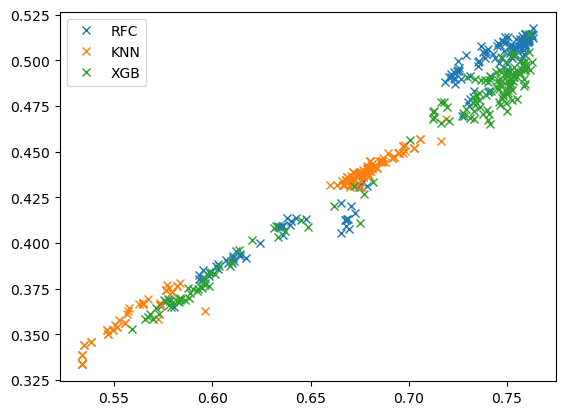

In [22]:
for model in results.model.unique():
    plot_data = results[results.model==model]
    plt.plot(plot_data.mean_test_f1_weighted, plot_data.mean_test_f1_macro, 'x', label=model)
    plt.legend()

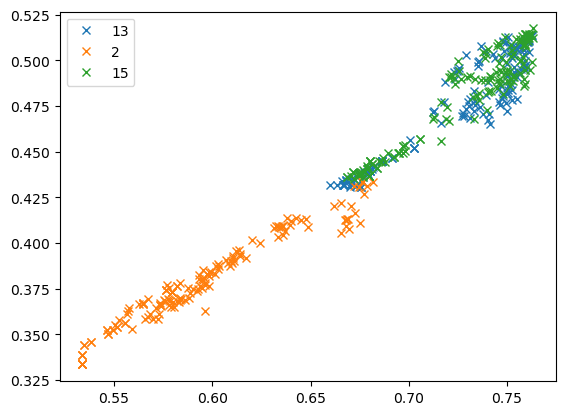

In [23]:
for model in results.num_features.unique():
    plot_data = results[results.num_features==model]
    plt.plot(plot_data.mean_test_f1_weighted, plot_data.mean_test_f1_macro, 'x', label=model)
    plt.legend()

In [24]:
choosen_current_model = results[results.mean_test_f1_macro > results.mean_test_f1_macro.max()*0.99].sort_values(by = ["mean_test_f1_weighted"])

In [25]:
choosen_current_model[["mean_test_f1_macro", "mean_test_f1_weighted", "params", "features"]]

,mean_test_f1_macro,mean_test_f1_weighted,params,features
146,0.513019,0.749045,"{'model__n_estimators': 500, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
28,0.512981,0.750414,"{'model__n_estimators': 500, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
104,0.513144,0.757679,"{'model__n_estimators': 500, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
132,0.514239,0.759144,"{'model__n_estimators': 400, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
113,0.514312,0.759221,"{'model__n_estimators': 500, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
143,0.514353,0.759430,"{'model__n_estimators': 600, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
129,0.512891,0.759961,"{'model__n_estimators': 50, 'model__min_sample...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
139,0.513469,0.760749,"{'model__n_estimators': 200, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
446,0.514404,0.760927,"{'model__subsample': 0.9, 'model__n_estimators...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."
138,0.513845,0.761215,"{'model__n_estimators': 600, 'model__min_sampl...","[slope_0.2, norm_slope_0.2, curvature, curvatu..."


In [26]:
#results.to_pickle("pipeline_random_search_PCA_SMOTE.pkl")

In [60]:
model_used=choosen_current_model.model.iloc[-1]

In [78]:
params = choosen_current_model.params.iloc[-1]

In [79]:
params = {key.replace('model__', ''): value for key, value in params.items()}

In [81]:
if model_used =="RFC":
    model=RandomForestClassifier(**params),
elif model_used == "XGB": 
    model= XGBClassifier(objective='multi:softmax', **params)
elif model_used == "KNN":
    model = KNeighborsClassifier(**params)

In [83]:
features = choosen_current_model.features.iloc[-1]

In [91]:
pipe = Pipeline([("scale", StandardScaler()),
                ("smote", SMOTE(random_state=42)),                         
                ("model", model[0])
                        ])

In [92]:
estimator = pipe.fit(X_train_df[features], y_train)

In [94]:
y_pred = estimator.predict(X_val_df[features])

In [95]:
f1_score(y_val.Y, y_pred, average='macro')

0.5199925420975055

In [96]:
f1_score(y_val.Y, y_pred, average='weighted')

0.7693609307402706

<Axes: >

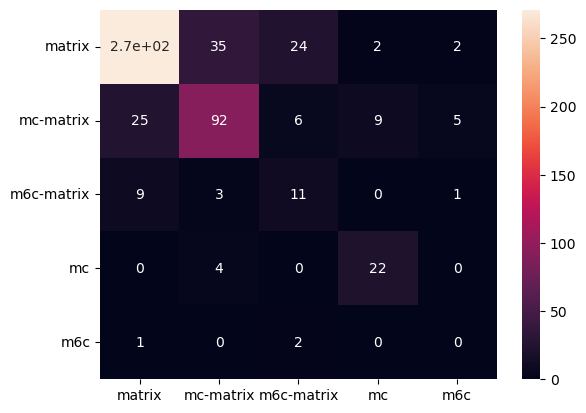

In [97]:
cm = confusion_matrix(y_val.Y, y_pred)
labels= {
    'matrix': 0,
    'mc-matrix': 1,
    'm6c-matrix': 2,
    'mc': 3,
    'm6c': 4,}
sns.heatmap(cm, annot=True,xticklabels=labels, yticklabels=labels)

In [99]:
results.to_pickle("pipeline_random_search_SMOTE_used_240822.pkl")